In [583]:
#!/Tsan/bin/python
# -*- coding: utf-8 -*-

In [584]:
# Libraries to use
from __future__ import division 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans

In [585]:
# Import My own library for factor testing
from SingleFactorTest import factorFilterFunctions as ff
#from config import *

In [586]:
%matplotlib inline

In [587]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [588]:
# make sure that matplotib and seaborn can show Chinese
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

In [589]:
# Files to use 
filenamePrice = 'Own_Factor_AdjustedPriceForward-1d.csv'
filenameST = 'LZ_GPA_SLCIND_ST_FLAG.csv'
filenameTradeday = 'LZ_GPA_SLCIND_TRADEDAYCOUNT.csv'
filenameStopFlag = 'LZ_GPA_SLCIND_STOP_FLAG.csv'
filenameIndu = 'LZ_GPA_INDU_ZX.csv'
filenameFCAP = 'LZ_GPA_VAL_A_FCAP.csv'
filenameAdjustFactor = 'LZ_GPA_CMFTR_CUM_FACTOR.csv'
filenameHS300 = 'LZ_GPA_INDXQUOTE_CLOSE.csv'
filenameZXIndustry = 'LZ_GPA_INDU_ZX.csv'
filenameZXExplanation = 'LZ_GPA_TMP_INDU_ZX.csv'

In [590]:
# Constants
startTime =  datetime.strptime('20161201', '%Y%m%d')
endTime = datetime.strptime('20170429', '%Y%m%d')

path = ff.data_path
timeStampNum = 2500
thresholdNum = 0.2
HS300Index ='000300.SH' # HS300 index code
ZZ500Index = '000905.SH' #   ZZ500 index code

In [591]:
stDF = pd.read_csv(path+filenameST,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
tradeDayDF = pd.read_csv(path+filenameTradeday,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
stopFlagDF = pd.read_csv(path+filenameStopFlag,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
indusDF = pd.read_csv(path+filenameZXIndustry,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
induExplanation = pd.read_csv(path+filenameZXExplanation,infer_datetime_format=True,parse_dates=[0],encoding='gb2312')

In [670]:
# Uqer factor
filenameUQAD20 = 'Uqer_factor_AD20.csv'    # group9最好，有2%左右的超额收益，其他组都没有超额收益，多空效果很好，有较好的单调性（但是单调性反转，长期是group0最小）（证明类动量/价因子还是效果比较好的）
filenameUQADTM = 'Uqer_factor_ADTM.csv'    # 因子失效中（没有超额收益），失去单调性
filenameUQATR6 = 'Uqer_factor_ATR6.csv'    # group1最好，有0.2%左右的超额收益，其他组都没有超额收益，多空效果很好，有较好的单调性
filenameUQAroon = 'Uqer_factor_Aroon.csv'   # 因子失效中（几乎没有超额收益），失去单调性 
filenameUQBias10 = 'Uqer_factor_BIAS10.csv' # 因子失效中（几乎没有超额收益），失去单调性 
filenameUQCCI10 = 'Uqer_factor_CCI10.csv'    #  因子失效中（几乎没有超额收益），失去单调性 
filenameUQKDJ_K = 'Uqer_factor_KDJ_K.csv'    # 因子失效中（几乎没有超额收益），失去单调性 
filenameROC6 = 'Uqer_factor_ROC6.csv'        # 无效因子 
filenameCMO = 'Uqer_factor_CMO.csv'          # 因子失去单调性
filenameRVI = 'Uqer_factor_RVI.csv'           # 无效银子
filenameRSI = 'Uqer_factor_RSI.csv'           # 价格波动率策略目前都处于失效中？（大概）

In [593]:
# Own factor
filenameOWNILLIQ ='Own_Factor_ILLQ-1d.csv'
filenameSharpe = 'Own_Factor_sharpe_ratio_20D.csv'

filenameTOV20 = 'Own_Factor_Turnover_Volatility_20D.csv' # group0 最好，有年化 10%的收益率，单调性很好，多空效果也很好，
 #但是市值单调递减，group0市值最大，可能选到了上证50（大市值股票交易比较稳定，因此换手率波动较小）
filenameADJTOV20 = 'Own_Factor_ADJ_Turnover_Volatility_20D.csv' # 单调性较好，但是没有超额收益 
filenameTOVD20 = 'Own_Factor_Turnover_Volatility_deviation_20D.csv' # 无单调性，无超额收益
filenameADJTOVD20 = 'Own_Factor_ADJ_Turnover_Volatility_Deviation_20D.csv' # 无单调性，无超额收益
filenameMOM1M = 'LZ_GPA_DERI_Momentum_1M.csv' # 一月反转

In [594]:
# yield/growth
filenameYOYGR = 'LZ_GPA_FIN_IND_QFA_YOYGR.csv'
filenameYOYROE = 'LZ_GPA_FIN_IND_YOYROE.csv'
filenameROE = 'LZ_GPA_FIN_IND_ROE.csv'

In [595]:
# value
filenamePS = 'LZ_GPA_VAL_PS.csv'  # group0 最好，有年化 5%的收益率，单调性很好，多空效果也很好
filenamePB ='LZ_GPA_VAL_PB.csv'  # group0 最好，有年化 12%的收益率，单调性很好，多空效果也很好 （神级因子）
filenamePE ='LZ_GPA_VAL_PE.csv'  #  group0 最好，有年化 10%的收益率，单调性不是特别完美，但不错，多空效果也很好 

In [596]:
#
filenameROE = 'LZ_GPA_FIN_IND_ROE.csv'
filenameRoeVol250 = 'Own_Factor_ROE_Volatility_250D.csv'

In [671]:
sololist = [filenameRSI]

In [672]:
sparedata = pd.read_csv(path+sololist[0],infer_datetime_format=True,parse_dates=[0],index_col=0)

In [673]:
# adjust the columns name of the Uqer data same as the own factor
if 'Uqer' in sololist[0]: 
    uqercolumnList = sparedata.columns.tolist()
    uqercolumnName = [x.split('.')[0] for x in uqercolumnList]
    newcolumnList = stDF.columns.tolist()
    newcolumnName = [x.split('.')[0] for x in newcolumnList]
    columndict = dict(zip(newcolumnName,newcolumnList))
    finalcolumns = []
    for stk in uqercolumnName:
        if stk in newcolumnName:
            stk = columndict[stk]
        else:
            pass
        finalcolumns.append(stk)
    sparedata.columns = finalcolumns
    addNanColumns = list(set(newcolumnList) - set(sparedata.columns))
    addData = pd.DataFrame(index = sparedata.index,columns = addNanColumns,dtype =float)
    sparedata = pd.concat([sparedata,addData],axis=1)
    sparedata = sparedata[newcolumnList]

In [674]:
priceData =  pd.read_csv(path+ filenamePrice ,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
benchMarkData = pd.read_csv(path+filenameHS300,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime][ZZ500Index]

In [675]:
LFCAPDF = np.log10(ff.getData(thresholdNum, startTime, endTime,filename = filenameFCAP))

In [676]:
LFCAPDF

,000005.SZ,600601.SH,600602.SH,600651.SH,600652.SH,600653.SH,600654.SH,000004.SZ,000002.SZ,000001.SZ,...,603577.SH,002832.SZ,300579.SZ,603058.SH,600996.SH,603298.SH,002833.SZ,002835.SZ,300582.SZ,603218.SH
LZ_GPA_VAL_A_FCAP-d,,,,,,,,,,,,,,,,,,,,,
2016-12-01,5.832980,6.042117,5.962139,5.956489,5.961952,5.888543,6.168674,5.540260,7.418016,7.147551,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-02,5.820563,6.033378,5.949452,5.944518,5.947681,5.880628,6.157182,5.535352,7.409560,7.145283,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-05,5.818157,6.028049,5.947732,5.946033,5.944833,5.872567,6.151205,5.539116,7.393675,7.141171,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-06,5.817553,6.028942,5.949023,5.944518,5.946733,5.867451,6.154663,5.545422,7.391626,7.142546,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-07,5.821761,6.031609,5.952872,5.946788,5.950196,5.874596,6.167115,5.557964,7.387500,7.142088,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-08,5.816343,6.025360,5.948163,5.939559,5.944197,5.869505,6.161951,5.552142,7.380534,7.143916,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-09,5.817553,6.024460,5.946438,5.938022,5.937792,5.867451,6.161499,5.552142,7.381761,7.149807,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-12,5.795245,5.998469,5.927898,5.907729,5.917312,5.843112,6.120265,5.518759,7.353744,7.143003,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-13,5.796515,5.996551,5.921080,5.913877,5.917650,5.842022,6.119269,5.526116,7.349994,7.139330,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595


In [677]:
endOfWeekList = sorted(list(set(LFCAPDF.iloc[LFCAPDF.resample('W').size().cumsum().sub(1)].index)))

In [678]:
endOfWeekList 

[Timestamp('2016-12-02 00:00:00'),
 Timestamp('2016-12-09 00:00:00'),
 Timestamp('2016-12-16 00:00:00'),
 Timestamp('2016-12-23 00:00:00'),
 Timestamp('2016-12-30 00:00:00'),
 Timestamp('2017-01-06 00:00:00'),
 Timestamp('2017-01-13 00:00:00'),
 Timestamp('2017-01-20 00:00:00'),
 Timestamp('2017-01-26 00:00:00'),
 Timestamp('2017-02-03 00:00:00'),
 Timestamp('2017-02-10 00:00:00'),
 Timestamp('2017-02-17 00:00:00'),
 Timestamp('2017-02-24 00:00:00'),
 Timestamp('2017-03-03 00:00:00'),
 Timestamp('2017-03-10 00:00:00'),
 Timestamp('2017-03-17 00:00:00'),
 Timestamp('2017-03-24 00:00:00'),
 Timestamp('2017-03-31 00:00:00'),
 Timestamp('2017-04-07 00:00:00'),
 Timestamp('2017-04-14 00:00:00'),
 Timestamp('2017-04-21 00:00:00'),
 Timestamp('2017-04-28 00:00:00')]

In [679]:
# calculate correlation between two factors
if  'Uqer' in sololist[0]:
    factor1 = sparedata.loc[startTime:endTime]
else:
    factor1 = pd.read_csv(path+sololist[0],infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
#correlationDF = ff.showCorrelation(factor1,LFCAPDF, endOfWeekList, filterdic = None).astype(float)
#correlationDF.describe()

In [680]:
activeReturnData = ff.calcReturn(priceData, endOfWeekList, benchmark = benchMarkData,activeReturn = True,logReturn = False)

In [681]:
# Generate the useles stock list
filterdict={}
for i in endOfWeekList:
    suspendList = ff.GetSTNewSuspend(i,stDF,tradeDayDF,stopFlagDF)
    filterdict[i] = suspendList
    print i, len(filterdict[i])

2016-12-02 00:00:00 391
2016-12-09 00:00:00 392
2016-12-16 00:00:00 404
2016-12-23 00:00:00 413
2016-12-30 00:00:00 404
2017-01-06 00:00:00 408
2017-01-13 00:00:00 416
2017-01-20 00:00:00 422
2017-01-26 00:00:00 428
2017-02-03 00:00:00 432
2017-02-10 00:00:00 445
2017-02-17 00:00:00 448
2017-02-24 00:00:00 457
2017-03-03 00:00:00 449
2017-03-10 00:00:00 446
2017-03-17 00:00:00 448
2017-03-24 00:00:00 451
2017-03-31 00:00:00 444
2017-04-07 00:00:00 448
2017-04-14 00:00:00 456
2017-04-21 00:00:00 451
2017-04-28 00:00:00 453


In [682]:
### Calculate the return of each group of given factor(solo factor)
totalGroupDict ={}
factorData = ff.getData(thresholdNum, startTime, endTime,availableData = factor1)

for date in endOfWeekList:
    factorDataTemp = factorData.loc[:date].tail()
    factorDataTemp = factorDataTemp[list(set(factorDataTemp.columns.tolist())- set(filterdict[date]))]
    #print factorDataTemp
    totalGroupDict[date] = ff.getStockGroup(factorDataTemp,groupNum=10,Mean_Num=1)

In [683]:
factorData

,000005.SZ,600601.SH,600651.SH,600652.SH,600653.SH,000004.SZ,000002.SZ,000001.SZ,000009.SZ,600603.SH,...,300573.SZ,603990.SH,002826.SZ,002827.SZ,603036.SH,603928.SH,002829.SZ,002830.SZ,300571.SZ,603708.SH
2016-12-01,35.1852,46.4286,40.7895,48.3871,55.1020,29.4926,50.3546,79.3651,41.5929,46.0377,...,100.0000,100.0000,100.0000,100.0000,100.0000,86.4334,100.0000,100.0000,100.0000,77.9395
2016-12-02,26.7606,20.0000,28.0172,40.3226,42.3077,12.2850,47.4388,73.5294,34.4000,46.0377,...,100.0000,100.0000,100.0000,100.0000,100.0000,86.4334,100.0000,100.0000,100.0000,77.9395
2016-12-05,26.0274,20.4082,31.0811,42.3729,36.6667,17.2370,35.3516,66.6667,56.0000,46.0377,...,100.0000,100.0000,100.0000,100.0000,100.0000,86.4334,100.0000,100.0000,100.0000,77.9395
2016-12-06,24.6575,25.5814,25.2381,45.7627,35.4839,25.4522,24.1150,70.6667,45.8647,46.0377,...,100.0000,100.0000,100.0000,100.0000,100.0000,86.4334,100.0000,100.0000,100.0000,77.9395
2016-12-07,32.0513,30.4348,23.7864,50.0000,44.6154,36.5188,24.5495,67.1429,58.1699,46.0377,...,100.0000,100.0000,100.0000,100.0000,100.0000,86.4334,100.0000,100.0000,100.0000,77.9395
2016-12-08,24.3902,23.5294,13.3005,37.2881,37.8788,29.6000,22.9958,62.9032,56.6667,46.0377,...,100.0000,100.0000,100.0000,100.0000,100.0000,86.4334,100.0000,100.0000,100.0000,77.9395
2016-12-09,24.3902,25.0000,16.2651,36.0656,28.3333,31.2802,24.5243,65.1515,55.5556,46.0377,...,100.0000,100.0000,100.0000,100.0000,100.0000,86.4334,100.0000,100.0000,100.0000,77.9395
2016-12-12,17.8571,16.6667,5.2863,29.3333,22.6667,24.9518,19.3656,51.8987,43.5897,46.0377,...,100.0000,100.0000,100.0000,100.0000,100.0000,86.4334,100.0000,100.0000,100.0000,77.9395
2016-12-13,18.5841,7.4627,11.4894,24.6445,23.2877,32.7655,15.0338,36.1111,45.5446,46.0377,...,100.0000,100.0000,100.0000,100.0000,100.0000,86.4334,100.0000,100.0000,100.0000,77.9395
2016-12-14,12.1739,7.4627,14.0000,24.7619,18.8406,39.1945,15.1618,34.2466,44.0191,46.0377,...,100.0000,100.0000,100.0000,100.0000,100.0000,86.4334,100.0000,100.0000,100.0000,77.9395


In [684]:
ReturnDF = pd.DataFrame(index=endOfWeekList[:-1],columns=totalGroupDict.values()[0].keys(),data=None, dtype =float)
sizeDistribution = pd.DataFrame(index=endOfWeekList[:-1],columns=totalGroupDict.values()[0].keys(),data=None, dtype =float)
for group in ReturnDF.columns.tolist():
    for time in ReturnDF.index:
        ReturnDF.loc[time][group] = activeReturnData.loc[time][totalGroupDict[time][group]].mean()
        sizeDistribution.loc[time][group] = LFCAPDF.loc[time][totalGroupDict[time][group]].quantile()
ReturnDF.sort_index(axis=1,inplace=True)
sizeDistribution.sort_index(axis=1,inplace=True)

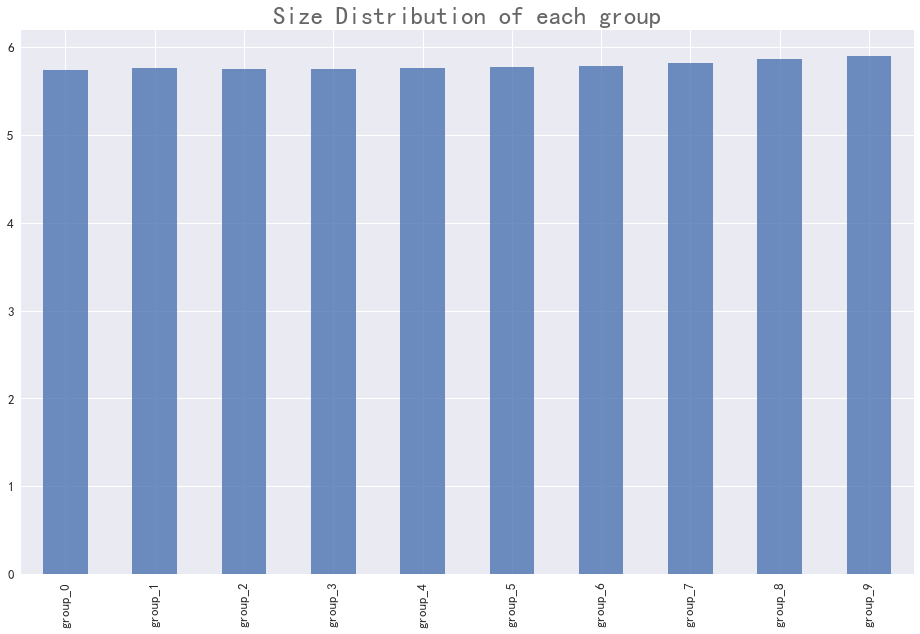

In [685]:
# show size distribution(quantile plot)
fig = plt.figure(figsize=(16,10))
# Add a subplot
ax = fig.add_subplot(111)
sizeDistribution.median().plot(kind='bar',ax = ax, fontsize =13,title ='Size Distribution of each group',alpha =0.8)
ax.set_title(ax.get_title(),alpha=0.7, fontsize=25)

In [686]:
# Calc spearman correlation to investigate monotonicity
referSeries = pd.Series(index = ReturnDF.columns, data=range(len(ReturnDF.columns)))
monoDF = pd.DataFrame(index = ReturnDF.index, columns=['Spearman_Cor'], dtype = float)
for date in ReturnDF.index:
    monoDF.loc[date] = ReturnDF.loc[date].corr(referSeries,method='spearman')   

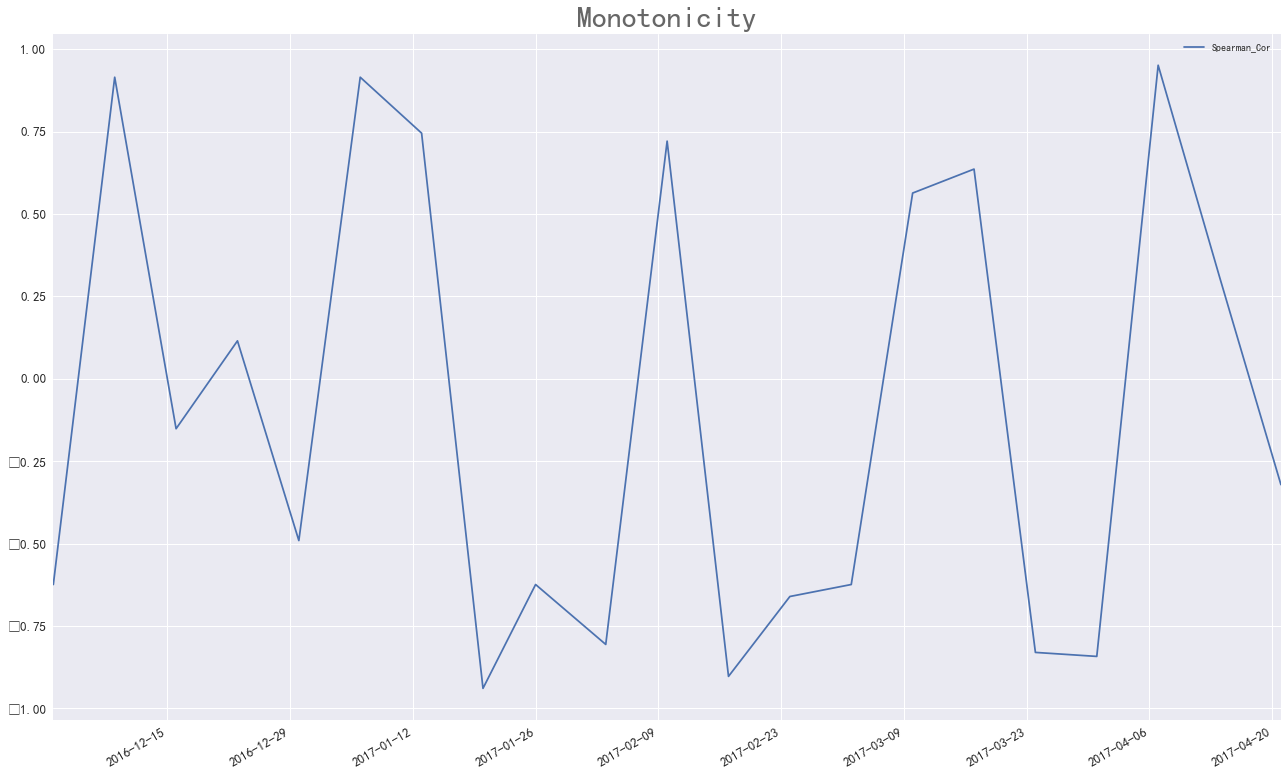

In [687]:
# Plot
fig = plt.figure(figsize=(18,14))
# Add a subplot
ax = fig.add_subplot(111)
monoDF.plot(figsize=(22,14),ax=ax,fontsize =13,title ='Monotonicity')
ax.set_title(ax.get_title(),alpha=0.7, fontsize=30)

In [688]:
# long top group short bot group 
sortGroups = ReturnDF[['group_0','group_9']].cumsum().iloc[-1].sort_values(ascending = False).index
top, bot = sortGroups[0], sortGroups[-1]

# Add another column
ReturnDF['top_bot_comb'] = ReturnDF[top] - ReturnDF[bot]

In [689]:
ReturnDF

,group_0,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9,top_bot_comb
2016-12-02,0.005757,0.000134,-0.003690,0.000473,-0.000673,0.000234,-0.003519,-0.000732,-0.002690,-0.005619,-0.011376
2016-12-09,-0.023254,-0.012912,-0.011157,-0.011422,-0.016245,-0.004743,0.001444,0.004889,0.005469,0.012617,0.035871
2016-12-16,-0.002192,0.002198,0.001696,0.000640,0.003766,-0.000406,0.002810,0.000663,0.001569,-0.009521,-0.007329
2016-12-23,0.002112,0.004041,0.004323,0.007749,0.007927,0.009709,0.004568,0.004324,0.004661,-0.003301,-0.005413
2016-12-30,0.000737,0.000444,0.000018,-0.000927,-0.001555,0.001671,0.001438,-0.000214,-0.001569,-0.011786,-0.012523
2017-01-06,-0.019811,-0.019128,-0.012359,-0.009850,-0.010501,-0.003337,-0.007286,-0.006767,-0.004772,-0.001392,0.018419
2017-01-13,-0.014764,-0.013646,-0.016554,-0.015186,-0.013486,-0.015996,-0.013245,-0.002728,-0.003446,0.011738,0.026503
2017-01-20,0.003237,0.005115,0.001193,0.002937,0.000520,-0.003936,0.000376,-0.000197,-0.005501,-0.010101,-0.013338
2017-01-26,0.003152,0.000046,-0.001105,-0.001186,-0.001854,-0.000651,-0.002610,-0.001221,-0.000108,-0.004393,-0.007545
2017-02-03,0.013617,0.011766,0.011518,0.009881,0.006973,0.004997,0.002841,0.007022,0.009363,-0.000190,-0.013807


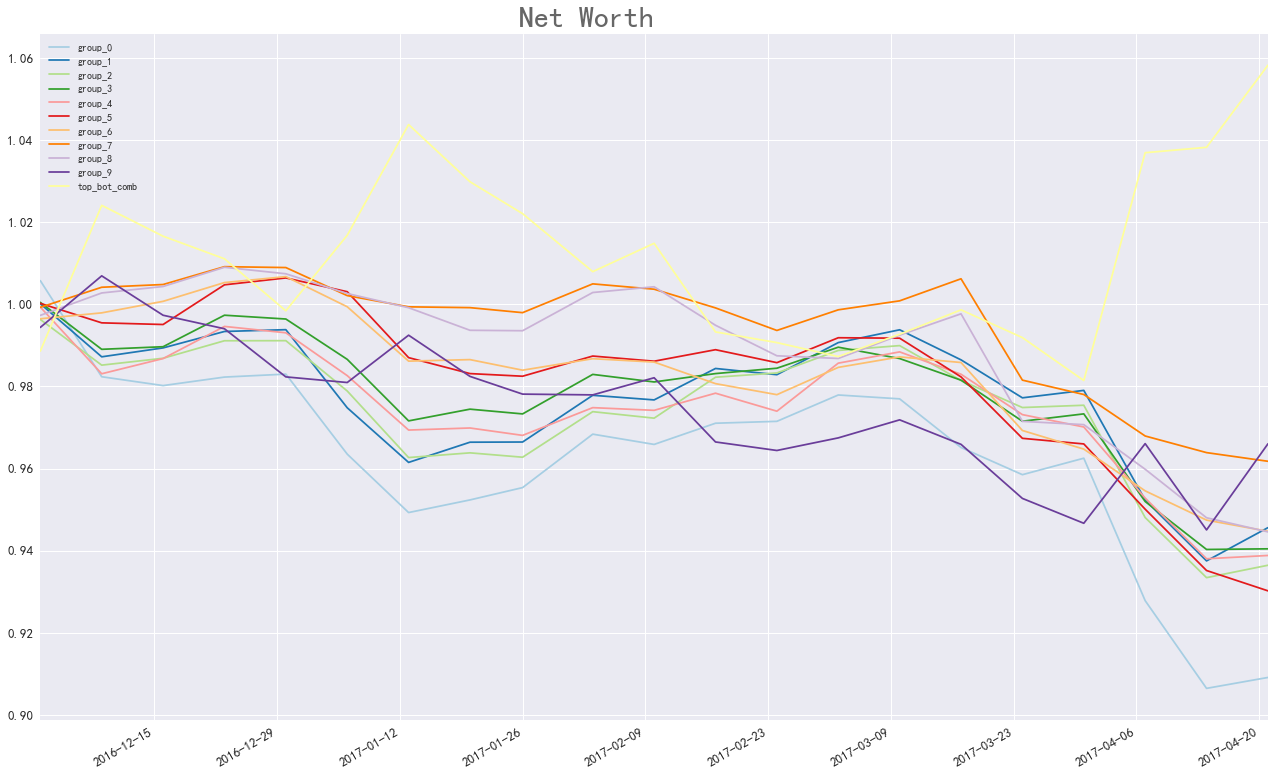

In [690]:
# Net worth plot 
netWorthDF = (ReturnDF.astype(float)+1).cumprod()
fig = plt.figure(figsize=(18,14))
# Add a subplot
ax = fig.add_subplot(111)
netWorthDF.plot(figsize=(22,14),ax=ax,color=sns.color_palette("Paired",11),title ='Net Worth',fontsize =13)
ax.set_title(ax.get_title(),alpha=0.7, fontsize=30, ha='right')

In [691]:
# Calc spearman correlation to investigate monotonicity
referSeries = pd.Series(index = netWorthDF.iloc[:,:-1].columns, data=range(len(netWorthDF.iloc[:,:-1].columns)))
monoDF = pd.DataFrame(index = netWorthDF.index, columns=['Spearman_Cor'], dtype = float)
for date in netWorthDF.index:
    monoDF.loc[date] = netWorthDF.iloc[:,:-1].loc[date].corr(referSeries,method='spearman')  

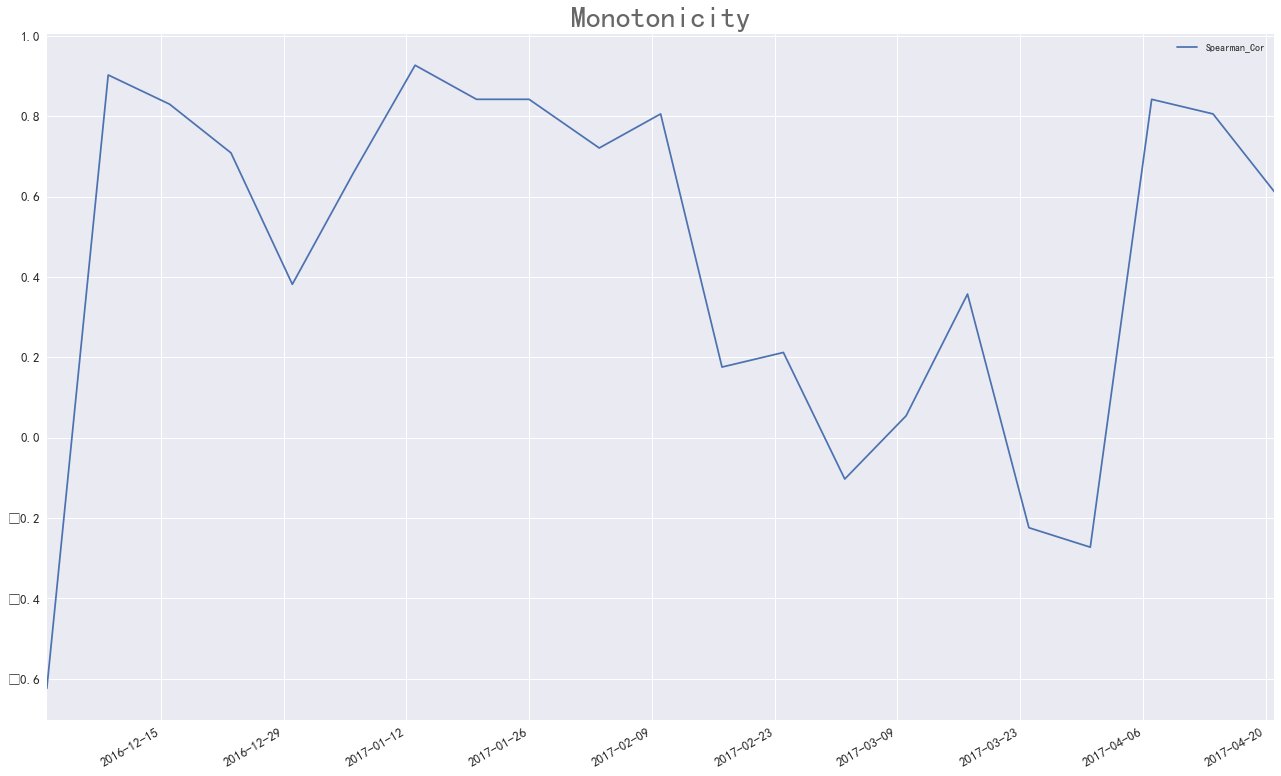

In [692]:
# Plot
fig = plt.figure(figsize=(18,14))
# Add a subplot
ax = fig.add_subplot(111)
monoDF.plot(figsize=(22,14),ax=ax,fontsize =13,title ='Monotonicity')
ax.set_title(ax.get_title(),alpha=0.7, fontsize=30)

In [693]:
# basic indicator
annualizedReturn = (1+ReturnDF.mean())**50 - 1
annualizedVol = ReturnDF.std()* np.sqrt(50)
sharpeRatio = annualizedReturn / annualizedVol 
print 'Annual Return:','\n',annualizedReturn,'\n\n','Annual Volatility:','\n',annualizedVol,'\n\n','Sharpe Ratio:''\n',sharpeRatio

Annual Return: 
group_0        -0.199860
group_1        -0.122403
group_2        -0.142785
group_3        -0.134624
group_4        -0.138035
group_5        -0.157014
group_6        -0.125830
group_7        -0.087565
group_8        -0.125561
group_9        -0.076135
top_bot_comb    0.153892
dtype: float64 

Annual Volatility: 
group_0         0.088196
group_1         0.072549
group_2         0.067400
group_3         0.056191
group_4         0.059022
group_5         0.052688
group_6         0.042047
group_7         0.048260
group_8         0.055904
group_9         0.080525
top_bot_comb    0.134673
dtype: float64 

Sharpe Ratio:
group_0        -2.266101
group_1        -1.687174
group_2        -2.118469
group_3        -2.395854
group_4        -2.338720
group_5        -2.980044
group_6        -2.992631
group_7        -1.814449
group_8        -2.246012
group_9        -0.945479
top_bot_comb    1.142703
dtype: float64


In [694]:
copyReturn = ReturnDF.copy()
copyReturn[copyReturn > copyReturn.mean()] =0
downsideRisk = ReturnDF.std(skipna = True) * np.sqrt(12)
downsideRisk

group_0         0.043207
group_1         0.035542
group_2         0.033019
group_3         0.027528
group_4         0.028915
group_5         0.025812
group_6         0.020599
group_7         0.023642
group_8         0.027387
group_9         0.039449
top_bot_comb    0.065976
dtype: float64

In [695]:
sortinoRatio = annualizedReturn / downsideRisk
sortinoRatio

group_0        -4.625659
group_1        -3.443930
group_2        -4.324307
group_3        -4.890516
group_4        -4.773892
group_5        -6.082990
group_6        -6.108682
group_7        -3.703729
group_8        -4.584653
group_9        -1.929950
top_bot_comb    2.332533
dtype: float64

In [696]:
# Max drawdown
maxdd = netWorthDF.copy()
maxdd.iloc[0] = 0
for date in netWorthDF.index[1:]:
    maxdd.loc[date] = 1-netWorthDF.loc[date]/netWorthDF.loc[:date].max()
maxddInfo = pd.concat([maxdd.max(),maxdd.idxmax()],axis=1)
maxddInfo.columns = ['Max_drawdown','Time']
maxddInfo

,Max_drawdown,Time
group_0,0.098678,2017-04-14
group_1,0.062581,2017-04-14
group_2,0.063081,2017-04-14
group_3,0.060123,2017-04-14
group_4,0.061308,2017-04-14
group_5,0.075686,2017-04-21
group_6,0.061580,2017-04-21
group_7,0.046944,2017-04-21
group_8,0.063834,2017-04-21
group_9,0.061420,2017-04-14


In [697]:
# calmar Ratio
calmarRatio = annualizedReturn/ maxddInfo['Max_drawdown']
calmarRatio

group_0        -2.025378
group_1        -1.955906
group_2        -2.263500
group_3        -2.239138
group_4        -2.251494
group_5        -2.074544
group_6        -2.043372
group_7        -1.865319
group_8        -1.966981
group_9        -1.239586
top_bot_comb    2.578002
dtype: float64

In [698]:
# show the difference of a risk factor through different market capitalzation size
# capdata should not contain Nan value
# Return: DICTIONARY, the KEY is the date and the Value is the tuple of the groups
# Inputs: 
# capdata: DATAFRAME ,the LFCAP DATA
# datelist: LIST, the datelist of the end month
def getGroupsbyCap(capdata, datelist):
    capdict ={}
    for date in datelist:
        capdataindice = capdata.loc[date]
        lower = capdataindice.quantile(1/3)
        upper = capdataindice.quantile(2/3)
        smallcap = capdataindice[capdataindice<=lower].index
        midcap = capdataindice[(lower<capdataindice) & (capdataindice<=upper)].index
        hugecap = capdataindice[capdataindice>upper].index
        capdict[date] = (smallcap,midcap,hugecap)
    return capdict

In [699]:
# show the difference of a risk factor through different industry
# capdata should not contain Nan value
# Return: DICTIONARY, the KEY is the date and the Value is the DICTIONARY of the groups of each industry on that day
# Inputs: 
# datelist: LIST, the datelist of the end month
# grouplable: LIST, the industry label,usually 3 of them is constant and other 3 is randomed  alike [2,3,6,15,18,25]
# industryDF: DATAFRAME,the industry dataframe(could )
def getIndustryDict(datelist,grouplabel,industryDF):
    industrydict = {}
    industryDF = industryDF.loc[datelist]
    for date in datelist:
        industryDFindice = industryDF.loc[date]
        industrydict[date] = {label:industryDFindice[industryDFindice == label].index for label in grouplabel}
    return industrydict

In [700]:
# industry number
grouplabel = np.random.choice(29,10,replace=False)
grouplabel

array([ 6,  2, 11,  8,  3,  1, 16, 28, 26, 10])

In [701]:
wholeIndList = np.array(range(29))
wholeIndDict = getIndustryDict(endOfWeekList,wholeIndList,indusDF)

In [702]:
multindexList = [endOfWeekList,wholeIndList]
induReturnDF  = pd.DataFrame(data=None, columns=totalGroupDict.values()[0].keys(),\
                             index=pd.MultiIndex.from_product(multindexList,names=['time','industry']),dtype=float)

In [703]:
groupNumberThrottle = 10
for i,j in wholeIndDict.iteritems():
    print i
    factorIndice = factorData.loc[:i].tail()
    factorIndice = factorIndice[list(set(factorIndice.columns.tolist())- set(filterdict[date]))]  # Remove ST ,new and suspend stk
    for ind, stk in j.iteritems():
        intersection = list(set(factorIndice.columns.tolist()) & set(stk))
        if len(intersection) < groupNumberThrottle:
            induReturnDF.loc[i,ind] = 0
            continue
        else:
            stkgroup = ff.getStockGroup(factorIndice[intersection], groupNum=10, Mean_Num=1)
            for p,q in stkgroup.iteritems():
                try:
                    induReturnDF.loc[i,ind][p] = activeReturnData.loc[i][q].mean()
                except:
                    induReturnDF.loc[i,ind][p] = np.NaN

2017-01-13 00:00:00
2017-01-20 00:00:00
2016-12-30 00:00:00
2016-12-02 00:00:00
2017-01-26 00:00:00
2017-02-17 00:00:00
2017-03-17 00:00:00
2017-03-24 00:00:00
2017-03-31 00:00:00
2016-12-09 00:00:00
2017-04-28 00:00:00
2016-12-16 00:00:00
2017-02-10 00:00:00
2017-04-14 00:00:00
2017-04-21 00:00:00
2017-01-06 00:00:00
2017-03-03 00:00:00
2016-12-23 00:00:00
2017-03-10 00:00:00
2017-02-24 00:00:00
2017-02-03 00:00:00
2017-04-07 00:00:00


In [704]:
finalReturn = induReturnDF.mean(level = 'time')
finalReturn.sort_index(axis=1,inplace=True)

In [705]:
sortGroups = finalReturn[['group_0','group_9']].cumsum().iloc[-1].sort_values(ascending = False).index
top, bot = sortGroups[0], sortGroups[-1]

# Add another column
finalReturn['top_bot_comb'] = finalReturn[top] - finalReturn[bot]

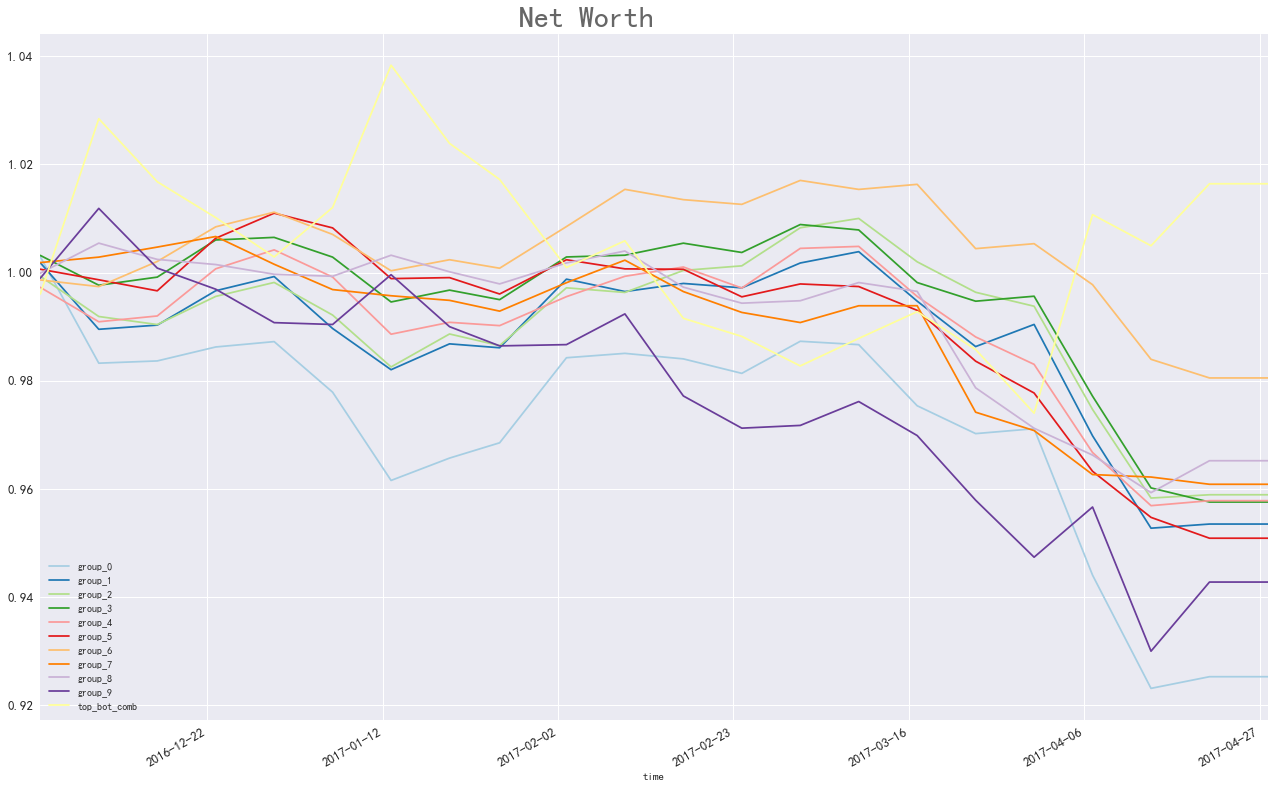

In [706]:
indNetWorth = (finalReturn+1).cumprod()
fig = plt.figure(figsize=(14,9))
# Add a subplot
ax = fig.add_subplot(111)
indNetWorth.plot(figsize=(22,14),ax=ax,color=sns.color_palette("Paired",11),title ='Net Worth',fontsize =13)
ax.set_title(ax.get_title(),alpha=0.7, fontsize=30, ha='right')